In [1]:
%load_ext autoreload
%autoreload 2

# IMPORT

In [41]:
import pandas as pd
from tqdm import tqdm

from src.process_tracking import process_data
from src.individual_pitch_control import extract_all_for_position_across_match, plot_half_pitch_individual_pitch_control, process_all_matches_parallel
from src.clustering import prepare_clustering_features_single_match, prepare_clustering_features_all_matches, predict_clusters, plot_cluster_summary_pitch_control, plot_players_cluster_distribution
from src.soccermap_models import predict_maps, compute_metrics
from src.analysis_plots import plot_player_percentiles, plot_isct_delta_by_player_single_match, plot_top_bottom_isct_delta
from src.run import run_all
from src.utils import concat_all_results

In [3]:
# Project_id GCP dans un .env
# Ajouter le code pour entraîner les modèles de DL
# finaliser abstract
# cleaner texte du notebook et vérifier nombre de mots
# soigner les plots (rajouter flèches directionnelles etc.)

Some details regarding the run of this project:

- To complete this project and get advanced results for a lot of matches, it is more convenient to save files at several steps (to reduce RAM usage, avoid having to rerun everything each time, etc.). 

- However you can run everything in this notebook without saving files : in each section, I have included both a cell to run the code on a single file without saving the output, and a cell to run it on multiple files and save the output locally (or in GCP).

- To make the run of this notebook easier, I have just pre-trained and saved required models in the repo (an example of clustering model and the 2 Deep Learning models in a lightweight format).

# PROCESS TRACKING DATA

Before going into the core of the topic, we must prepare tracking data:
- Rescale coordinates to a 105x68 pitch
- Calculate velocities
- Retrieve meta data and merge with event data
- Normalize directions (always attacking left to right)

In [6]:
# RUN ON A SINGLE MATCH

df_processed = process_data(match_id=1886347, save=False)

[match 1886347] rows: 724617, players: 693106, ball: 31511


Merging match 1886347: 100%|██████████| 999/999 [00:03<00:00, 286.93it/s]


In [12]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

match_ids = [1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461]

for match_id in tqdm(match_ids, total=len(match_ids)):
    process_data(match_id=match_id, save=True, save_load_method="local")

  0%|          | 0/10 [00:00<?, ?it/s]

[match 1886347] rows: 724617, players: 693106, ball: 31511



 10%|█         | 1/10 [00:22<03:19, 22.13s/it]

[match 1899585] rows: 663170, players: 634338, ball: 28832


/home/jupyter/Arthur/analytics_cup_research/src/process_tracking.py:169: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)

 20%|██        | 2/10 [00:41<02:44, 20.53s/it]

[match 1925299] rows: 806107, players: 771049, ball: 35058



 30%|███       | 3/10 [01:05<02:33, 21.89s/it]

[match 1953632] rows: 746548, players: 714087, ball: 32461



 40%|████      | 4/10 [01:26<02:10, 21.73s/it]

[match 1996435] rows: 734608, players: 702665, ball: 31943



 50%|█████     | 5/10 [01:48<01:49, 21.83s/it]

[match 2006229] rows: 732849, players: 700981, ball: 31868



 60%|██████    | 6/10 [02:11<01:28, 22.10s/it]

[match 2011166] rows: 625018, players: 597838, ball: 27180



 70%|███████   | 7/10 [02:29<01:02, 20.89s/it]

[match 2013725] rows: 710491, players: 679596, ball: 30895



 80%|████████  | 8/10 [02:50<00:42, 21.03s/it]

[match 2015213] rows: 708668, players: 677855, ball: 30813



 90%|█████████ | 9/10 [03:12<00:21, 21.17s/it]

[match 2017461] rows: 642482, players: 614542, ball: 27940


/home/jupyter/Arthur/analytics_cup_research/src/process_tracking.py:169: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)

100%|██████████| 10/10 [03:32<00:00, 21.22s/it]


# CALCULATE INDIVIDUAL PITCH CONTROL

As explained in the abstract, the objective of the project is to analyse and evaluate the space controled by a given player position in a given game situation.

In this notebook, we have pre-selected :
- player position : **center forwards** 
- game situation : **team out of possession is low block**

But the code works for any player position and any game situation, so feel free to change the values below !

In [8]:
player_position = "center_forward"
game_situation = ('team_out_of_possession_phase_type','low_block')

This first step enables to calculate what we call the "Individual Pitch Control" (IPC), which is the Spearman's physics-based Pitch Control model definition, applied only to a single player : instead of summing the probabilities of each player of the teams, we only take into account the probability of a single player of a team and the sum of the probabilities of all the players of the opponent team. We do that to focus only on the space created by this player.
The output is a (32x50) map of the half-pitch.

We also calculate features that describe the game situation and that we will include in our clustering model (next step) : opponent defensive lines (calculated with an Agglomerative Clustering method) and contextual information about the player we focus on (distance from the ball, from nearest opponent, etc.)

The output is a list of dictionaries (one frame per dictionary), with both the IPC map and the contextual features

In [7]:
# RUN ON A SINGLE MATCH

results = extract_all_for_position_across_match(
        match_id=1886347,
        player_position=player_position,
        game_situation=game_situation,
        df=df_processed,
        sample_size=5,
        resolution=1,
        #save_load_method = "local"
    )


 Processing complete: 5 frames analyzed in total.


In [8]:
results[0]

{'pitch_control_map': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'defensive_lines': [72.40961538461539, 79.15889423076923, 88.67740384615385],
 'frame': 26468,
 'player_id': 38673,
 'player_position': (88.84615384615384, 23.450000000000003),
 'ball_position': (73.31826923076923, 57.18),
 'in_possession': False,
 'distance_to_ball': 37.13257465660976,
 'distance_to_nearest_teammate': 8.715640927811586,
 'distance_to_nearest_opponent': 7.5157722477240965,
 'player_position_role': 'center_forward'}

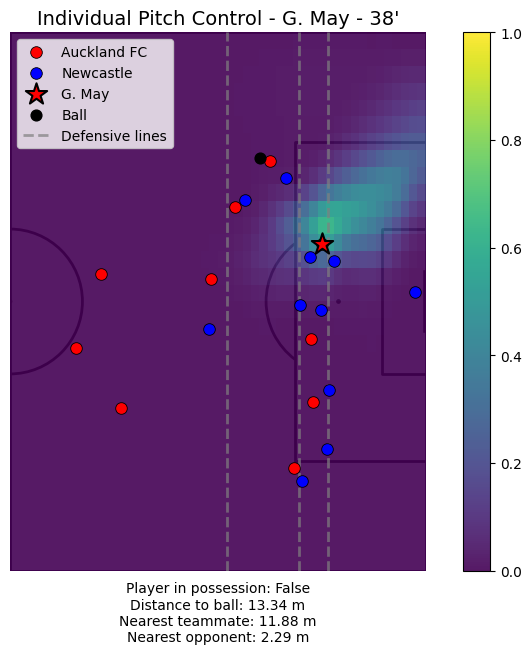

In [9]:
plot_half_pitch_individual_pitch_control(
    df=df_processed,
    frame_results=results[1]
)

In [4]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

process_all_matches_parallel(
    player_position=player_position,
    game_situation=game_situation,
    pitch_control_resolution= 1,
    max_workers= 10,
    save = True,
    save_load_method = "local"
)

10 matches detected
 Processing match 2013725... Processing match 1996435... Processing match 2006229... Processing match 1953632... Processing match 1899585... Processing match 2011166... Processing match 2015213... Processing match 1925299... Processing match 2017461...
 Processing match 1886347...











 Processing complete: 145 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/1953632.npz



 Processing complete: 129 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/2015213.npz



 Processing complete: 212 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/2017461.npz



 Processing complete: 154 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/2013725.npz



 Processing complete: 179 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/2011166.npz



 Processing complete: 197 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/2006229.npz



 Processing complete: 210 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/1886347.npz



 Processing complete: 282 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/1996435.npz



 Processing complete: 258 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/1899585.npz



 Processing complete: 294 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_low_block/1925299.npz


# IDENTIFY SPACE CLUSTERS

This second step enables to identify the main types of space controlled by a player (with always the focus of player position x game situation).

Thus we can determine player profiles about the spaces they create (and in the next step we will be able to evaluate how efficient and dangerous the spaces for each cluster).

In [11]:
# RUN ON A SINGLE MATCH

X_single_match, meta_single_match = prepare_clustering_features_single_match(
    results= results,
    processed_df= df_processed,
    match_id= 1886347,
    game_situation= game_situation
)

meta_single_match = predict_clusters(
    player_position=player_position, 
    game_situation=game_situation, 
    X=X_single_match, 
    meta=meta_single_match, 
    model_local=True
)

In [12]:
meta_single_match

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,game_situation,cluster,cluster_gathered
0,1886347,28046,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,0,low_block,1,1
1,1886347,23046,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,38,low_block,8,3
2,1886347,13261,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,22,low_block,3,1
3,1886347,50111,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,37,low_block,7,4


In [4]:
# RUN ON ALL MATCHES AND SAVE OUTPUTS

X_all_matches, meta_all_matches, frames_inputs_all_matches = prepare_clustering_features_all_matches(
    player_position=player_position,
    game_situation=game_situation,
    save_load_method="local"
)

meta_all_matches = predict_clusters(
    player_position=player_position, 
    game_situation=game_situation, 
    X=X_all_matches, 
    meta=meta_all_matches, 
    model_local=True
)

100%|██████████| 10/10 [00:01<00:00,  9.54it/s]


In [17]:
meta_all_matches

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,game_situation,cluster,cluster_gathered
0,1886347,301,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,0,low_block,1,1
1,1886347,350,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,0,low_block,0,0
2,1886347,1102,966120,center_forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,0,0
3,1886347,1122,966120,center_forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,3,1
4,1886347,1204,966120,center_forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1517,2017461,52985,38673,center_forward,G. May,Auckland FC,Melbourne Victory Football Club,22,low_block,1,1
1518,2017461,53465,38673,center_forward,G. May,Auckland FC,Melbourne Victory Football Club,22,low_block,0,0
1519,2017461,53474,38673,center_forward,G. May,Auckland FC,Melbourne Victory Football Club,23,low_block,1,1
1520,2017461,53503,38673,center_forward,G. May,Auckland FC,Melbourne Victory Football Club,23,low_block,1,1


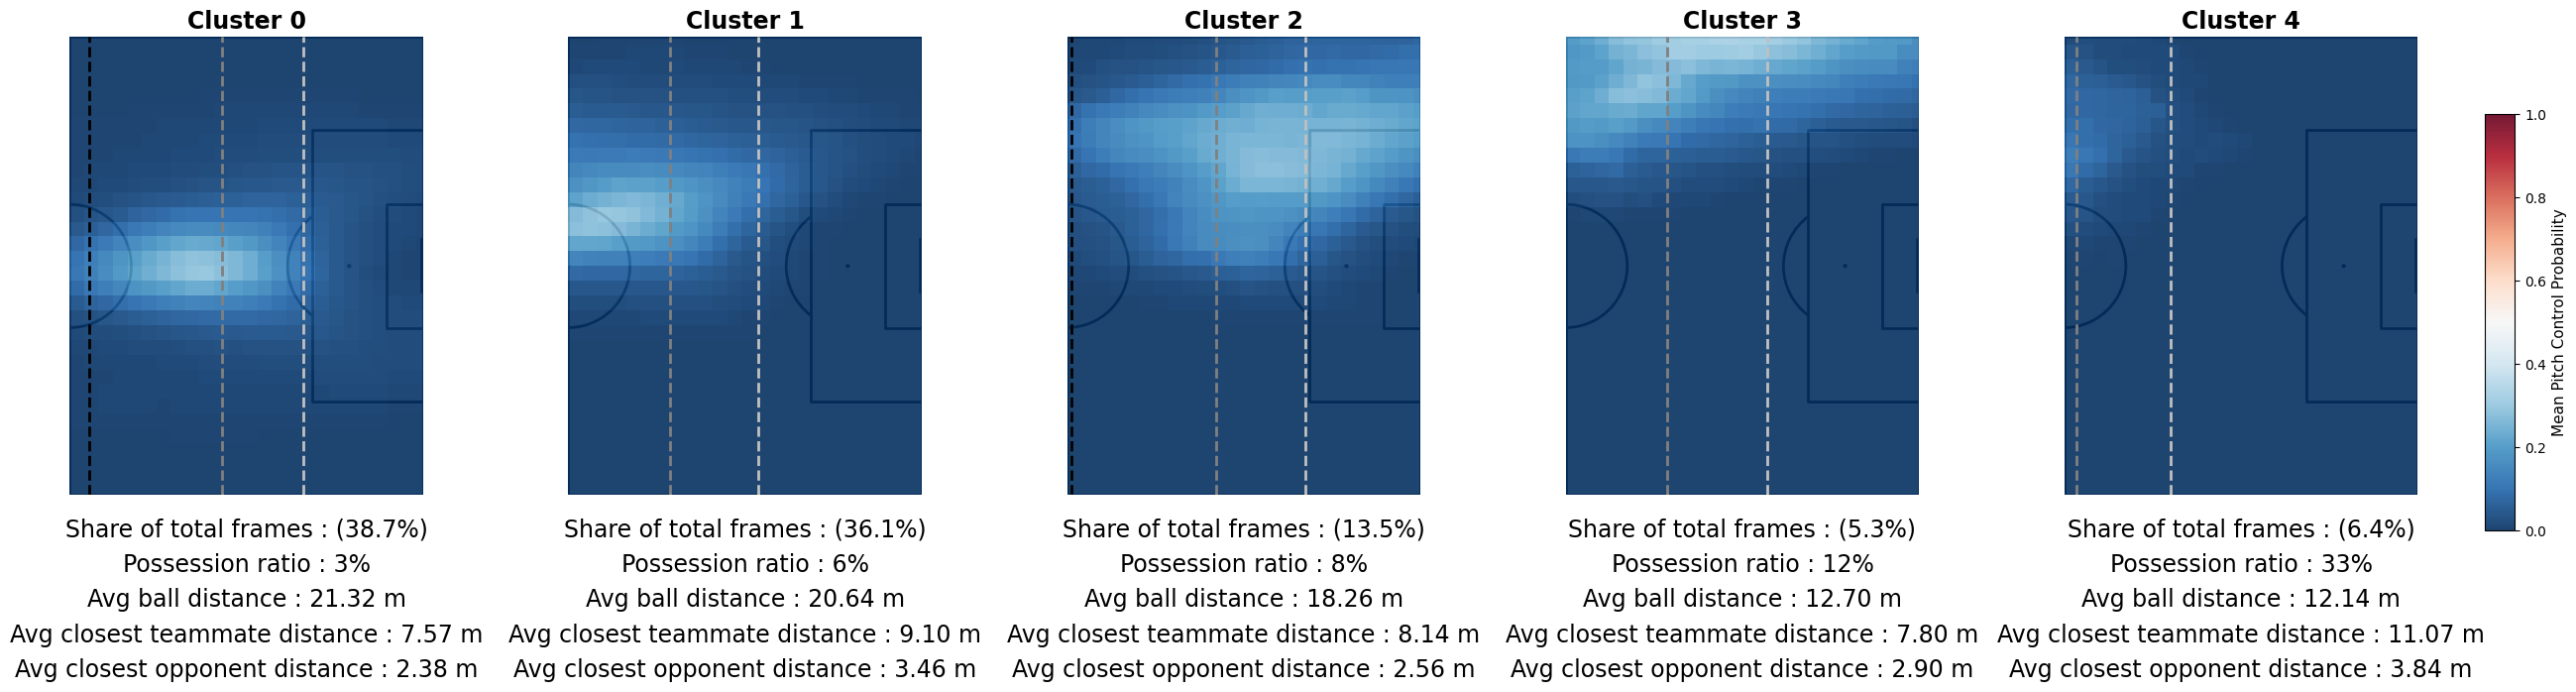

In [20]:
plot_cluster_summary_pitch_control(
    results=frames_inputs_all_matches,
    meta=meta_all_matches
)

The space categories for center forwards against low block defense can be interpreted as below :
- cluster 0 : In the center, between defensive lines / Rarely with the ball (not participating to build-up) / Most frequent pitch control
- cluster 1 : In the center/slightly on the side / Around the 2nd defensive line / Rarely with the ball (not participating to build-up)
- cluster 2 : Slightly on the side / Covering in front of and behind last defensive line, ready for runs in behind / Most offensive pitch control
- cluster 3 : On the side / Going back or lateral to create spaces for build-up (often with the ball) / Spaces closer to the ball
- cluster 4 : On the side / Going back or lateral to create spaces for build-up (often with the ball) / Spaces closer to the ball

In this repo, you will only find this pre-trained clustering model (for center forward x low block defense).
You can find the function to train your clustering model on the player position and game situation of your choice (but it requires iterations and interpretations).

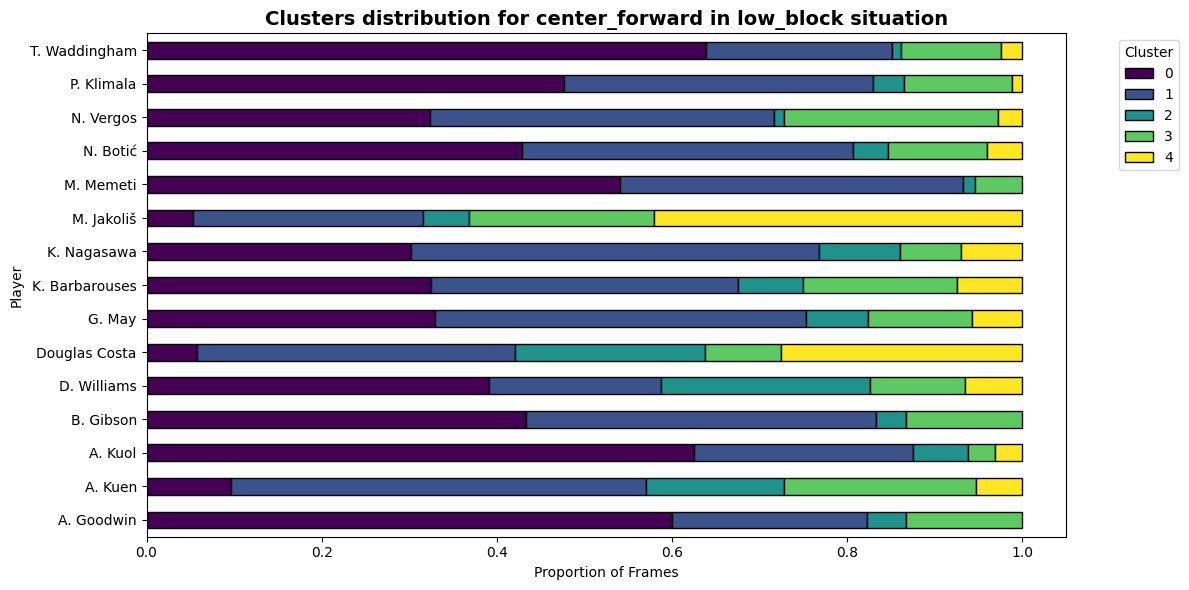

In [21]:
plot_players_cluster_distribution(
    meta=meta_all_matches
)

# EVALUATE SPACES WITH SOCCERMAP MODELS

The last step consists in evaluating the relevancy and the danger of the space created by the player.
To do so, we leverage the Soccermap approach to train 2 CNN models :
- xPass (enables to evaluate the "relevancy" of the space : is the space realistic and reachable ?)
- XThreat (enables to evaluate the "danger" of the space : how likely is the team to score in the 10 next seconds if the ball goes to the space ?)

We introduce the metric **"iscT" : Individual Space Controlled Threat** :
- It is the weighted average of the xT of the spaces controlled by the player, weighted by the Individual Pitch Control and the xPass probabilities
- Intuition : the more likely the player is to control the space — and for a pass into that space to be successful — the more weight we assign to the xT


To make this metric usable — i.e. to be able to compare different situations and different players — we prefer to analyze how much these controlled spaces would increase the probability of scoring compared to the on-ball xT : **iscT-Δ : Individual Space Controlled Threat Increase**

/home/jupyter/Arthur/analytics_cup_research/src/soccermap_models.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:


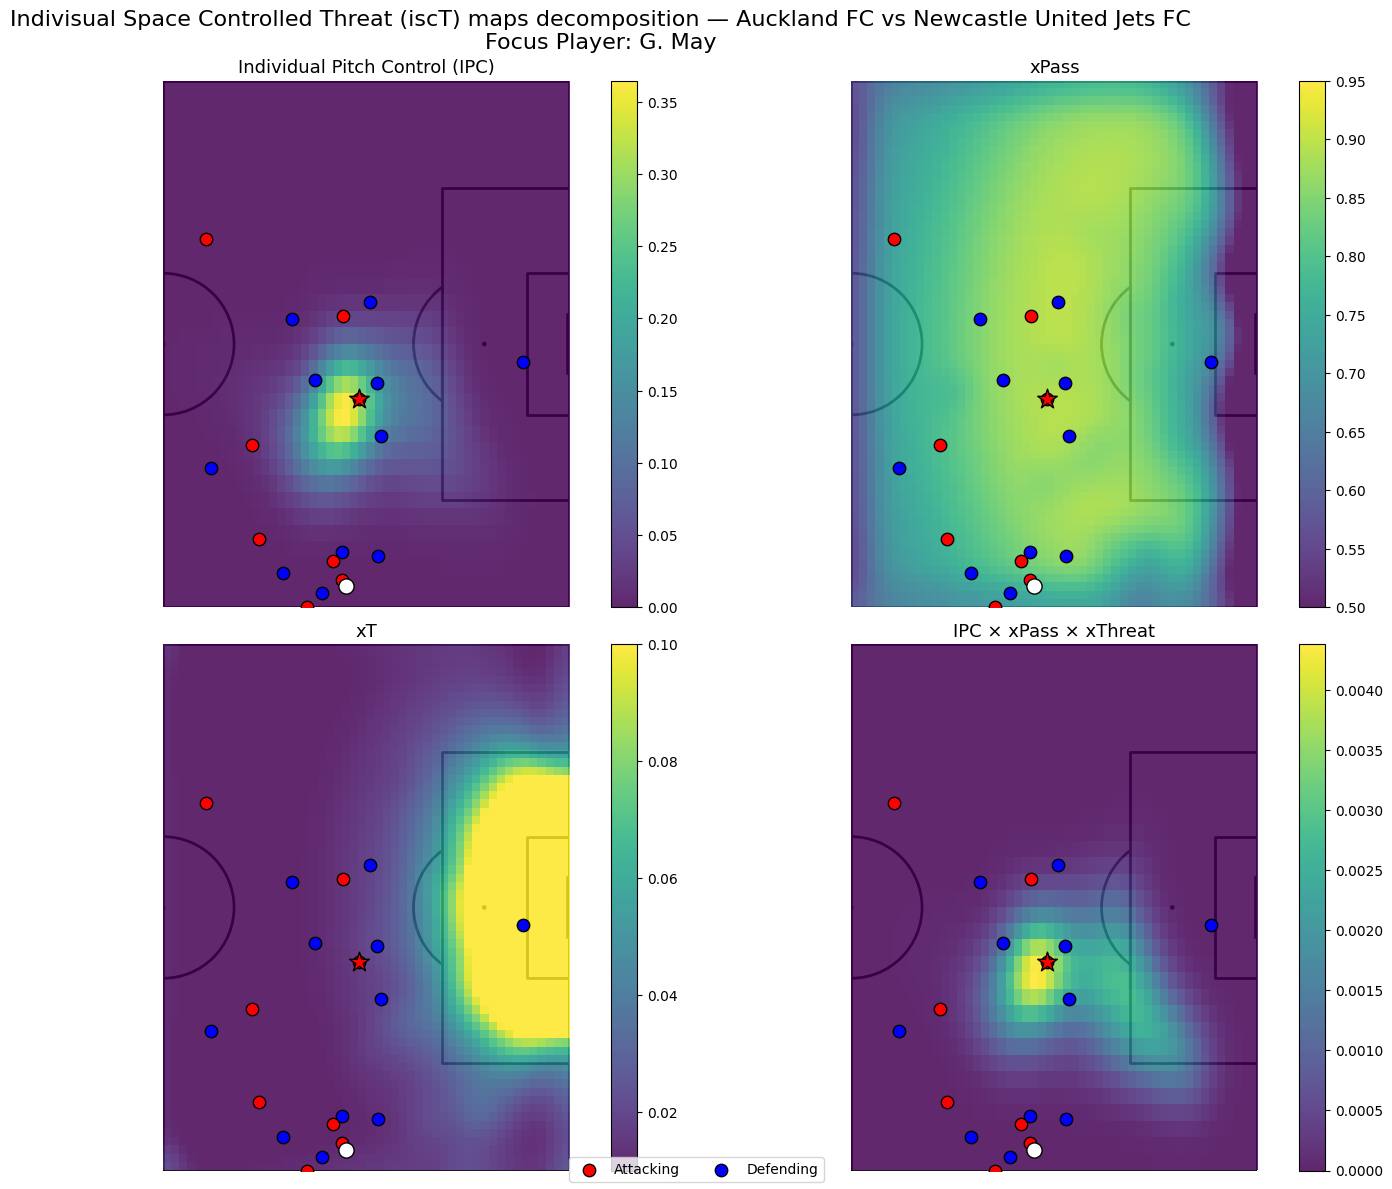

In [25]:
iscT, iscT_delta = predict_maps(
    match_id=1886347,
    df=df_processed,
    frame_results=results,
    frame=results[3]['frame'],
    model_local=True
)

/home/jupyter/Arthur/analytics_cup_research/src/soccermap_models.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else:


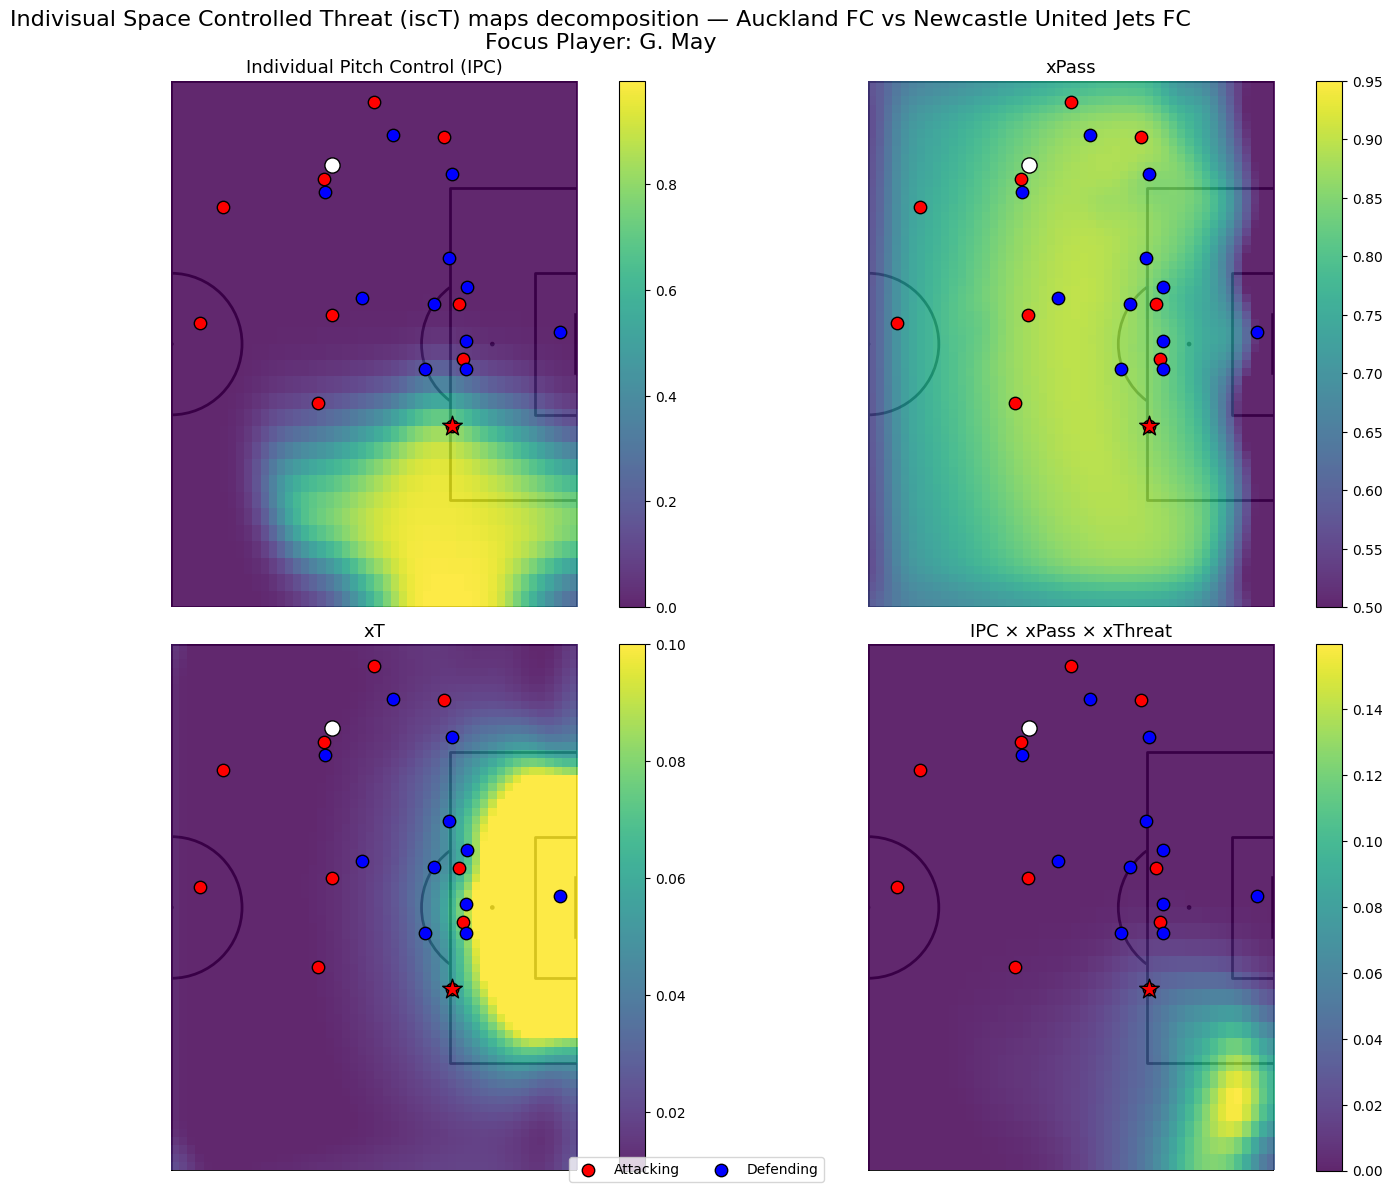

In [26]:
iscT, iscT_delta = predict_maps(
    match_id=1886347,
    frame=26468,
    player_position=player_position,
    game_situation=game_situation,
    model_local=True
)

In [27]:
meta_single_match = compute_metrics(
    meta=meta_single_match,
    df=df_processed,
    frame_results=results,
    model_local=True,
    batch_size=32
)

Matches: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


In [28]:
meta_single_match

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,game_situation,cluster,cluster_gathered,iscT,iscT_delta
0,1886347,28046,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,0,low_block,1,1,0.011421,-0.096724
1,1886347,23046,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,38,low_block,8,3,0.032029,-0.011129
2,1886347,13261,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,22,low_block,3,1,0.020511,0.017732
3,1886347,50111,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,37,low_block,7,4,0.011798,-0.362013


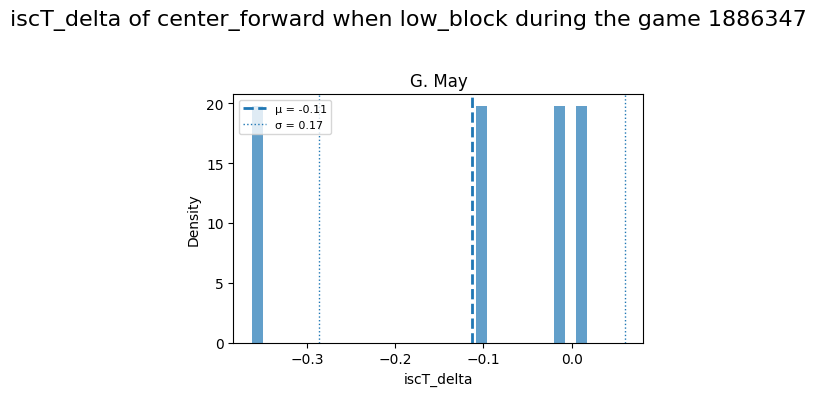

In [29]:
plot_isct_delta_by_player_single_match(meta_single_match)

In [7]:
meta_all_matches = compute_metrics(
    meta=meta_all_matches,
    batch_size=32,
    save = True,
    save_load_method = "local"
)

Matches: 100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


# RUN ALL AND ANALYZE

For the cell below, it is more insighful to run them on all matches (to be able to compare all players of a given player_position of the league) and all game situations.

The already run cells below are based on my saved outputs.

You can also use the wrap-up final functions to save your outputs and then run those cells

In [3]:
player_position = "center_forward"
game_situation_new = ('team_in_possession_phase_type','build_up')

In [9]:
meta_out = run_all(
    player_position=player_position, 
    game_situation=game_situation_new,
    save = True,
    save_load_method = "local"
)

10 matches detected
1) Calculate Individual Pitch Control
10 matches detected
 Processing match 2013725... Processing match 2006229... Processing match 1996435... Processing match 1953632... Processing match 1899585... Processing match 2011166... Processing match 2015213... Processing match 1925299... Processing match 2017461... Processing match 1886347...












 Processing complete: 58 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/2017461.npz



 Processing complete: 92 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/2011166.npz



 Processing complete: 120 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/1899585.npz



 Processing complete: 153 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/1953632.npz



 Processing complete: 149 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/1925299.npz



 Processing complete: 163 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/1886347.npz



 Processing complete: 165 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/2013725.npz



 Processing complete: 204 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/1996435.npz



 Processing complete: 173 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/2015213.npz



 Processing complete: 185 frames analyzed in total.
 File saved: outputs/pitch_control_center_forward_build_up/2006229.npz
2) Predict spaces clusters if a clustering model is available


100%|██████████| 10/10 [00:00<00:00, 12.05it/s]


Pipeline not found locally: models/clustering_pipeline_center_forward_build_up.joblib
3) Run xPass and xT predictions and calculate iscT metrics


Matches: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


In [48]:
meta_all_matches = concat_all_results(save_load_method="all")

In [4]:
meta_all_matches

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,game_situation,cluster,cluster_gathered,iscT,iscT_delta
0,1886347,301,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,0,low_block,1,1,0.019625,0.001207
1,1886347,350,38673,center_forward,G. May,Auckland FC,Newcastle United Jets FC,0,low_block,0,0,0.036378,0.026936
2,1886347,1102,966120,center_forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,0,0,0.086386,0.080071
3,1886347,1122,966120,center_forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,3,1,0.054419,0.048736
4,1886347,1204,966120,center_forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,low_block,1,1,0.016362,-0.314986
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,2017461,50295,38673,center_forward,G. May,Auckland FC,Melbourne Victory Football Club,17,build_up,None,None,0.011126,-0.016192
2576,2017461,52995,29075,center_forward,N. Vergos,Melbourne Victory Football Club,Auckland FC,22,build_up,None,None,0.008919,0.005746
2577,2017461,53017,29075,center_forward,N. Vergos,Melbourne Victory Football Club,Auckland FC,22,build_up,None,None,0.007419,0.000464
2578,2017461,62029,38673,center_forward,G. May,Auckland FC,Melbourne Victory Football Club,37,build_up,None,None,0.007653,-0.000141


In [54]:
meta_all_matches.player_name.value_counts()

player_name
G. May            588
N. Botić          320
T. Waddingham     276
N. Vergos         245
P. Klimala        235
A. Kuen           204
Douglas Costa     136
K. Nagasawa       135
M. Memeti         127
A. Goodwin        116
D. Williams       111
K. Barbarouses    111
B. Gibson         101
A. Kuol            98
M. Jakoliš         66
Name: count, dtype: int64

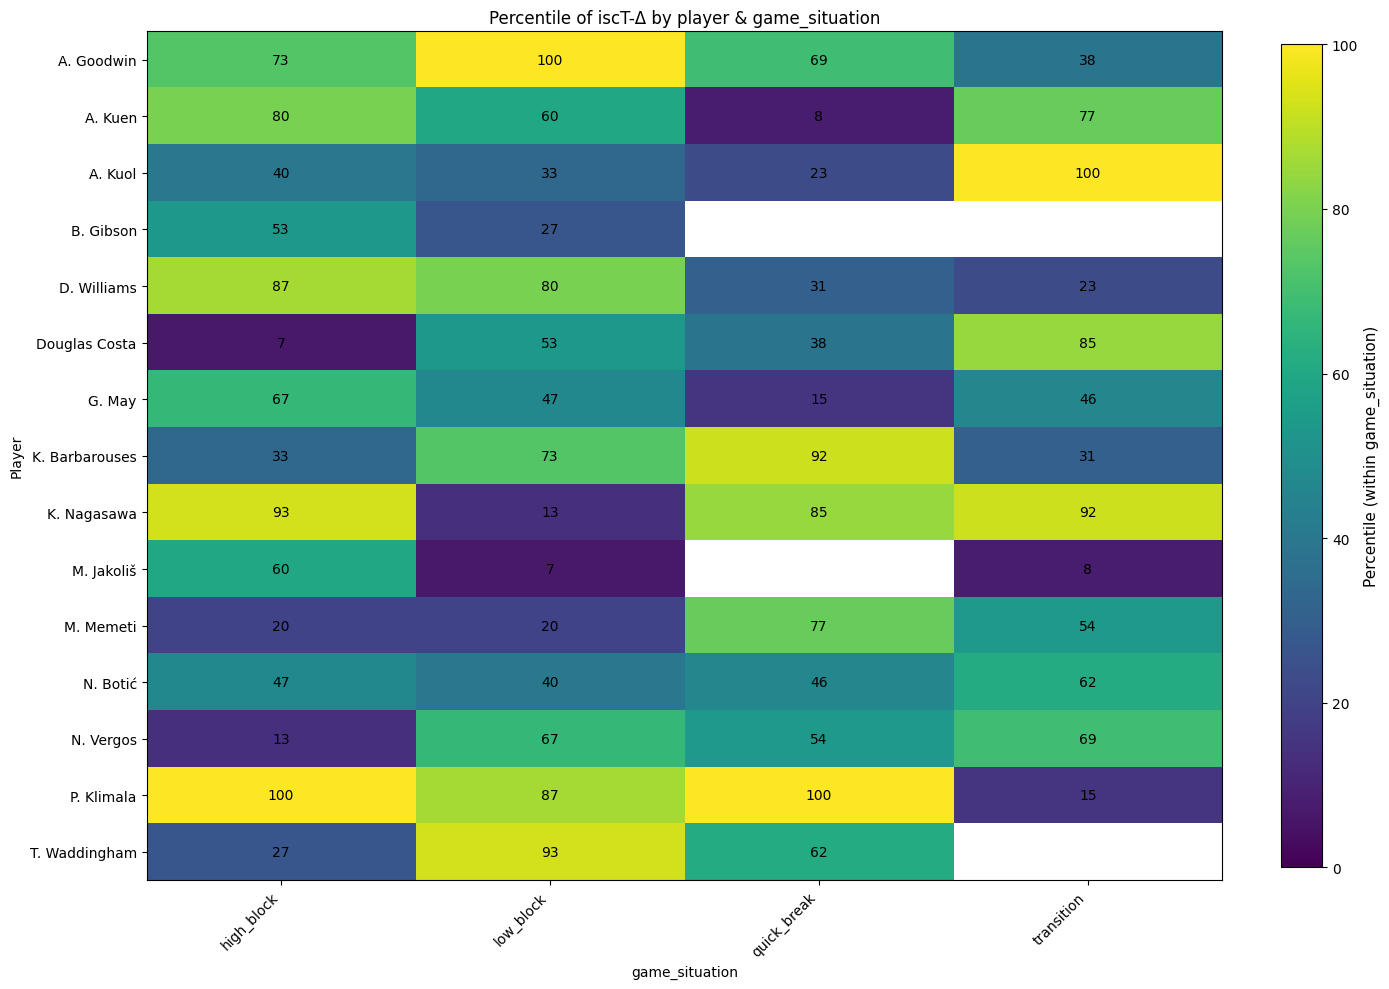

In [49]:
pivot_percentiles = plot_player_percentiles(
    meta_out=meta_all_matches,
    dimension_col="game_situation"
)

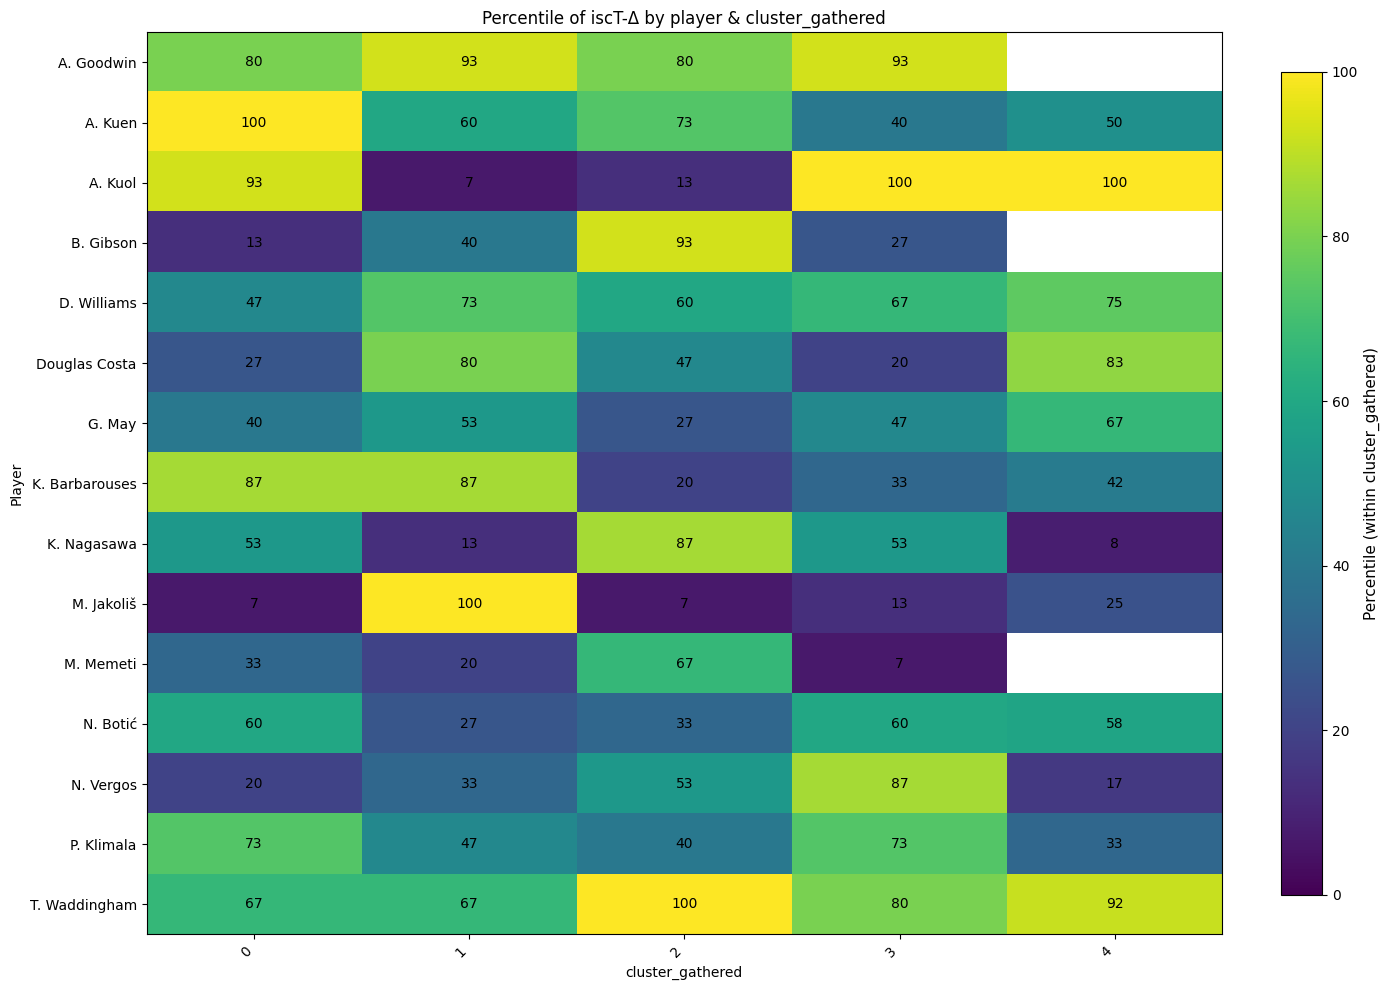

In [32]:
pivot_percentiles = plot_player_percentiles(
    meta_out=meta_all_matches,
    dimension_col="cluster_gathered",
    game_situation_filter="low_block"
)

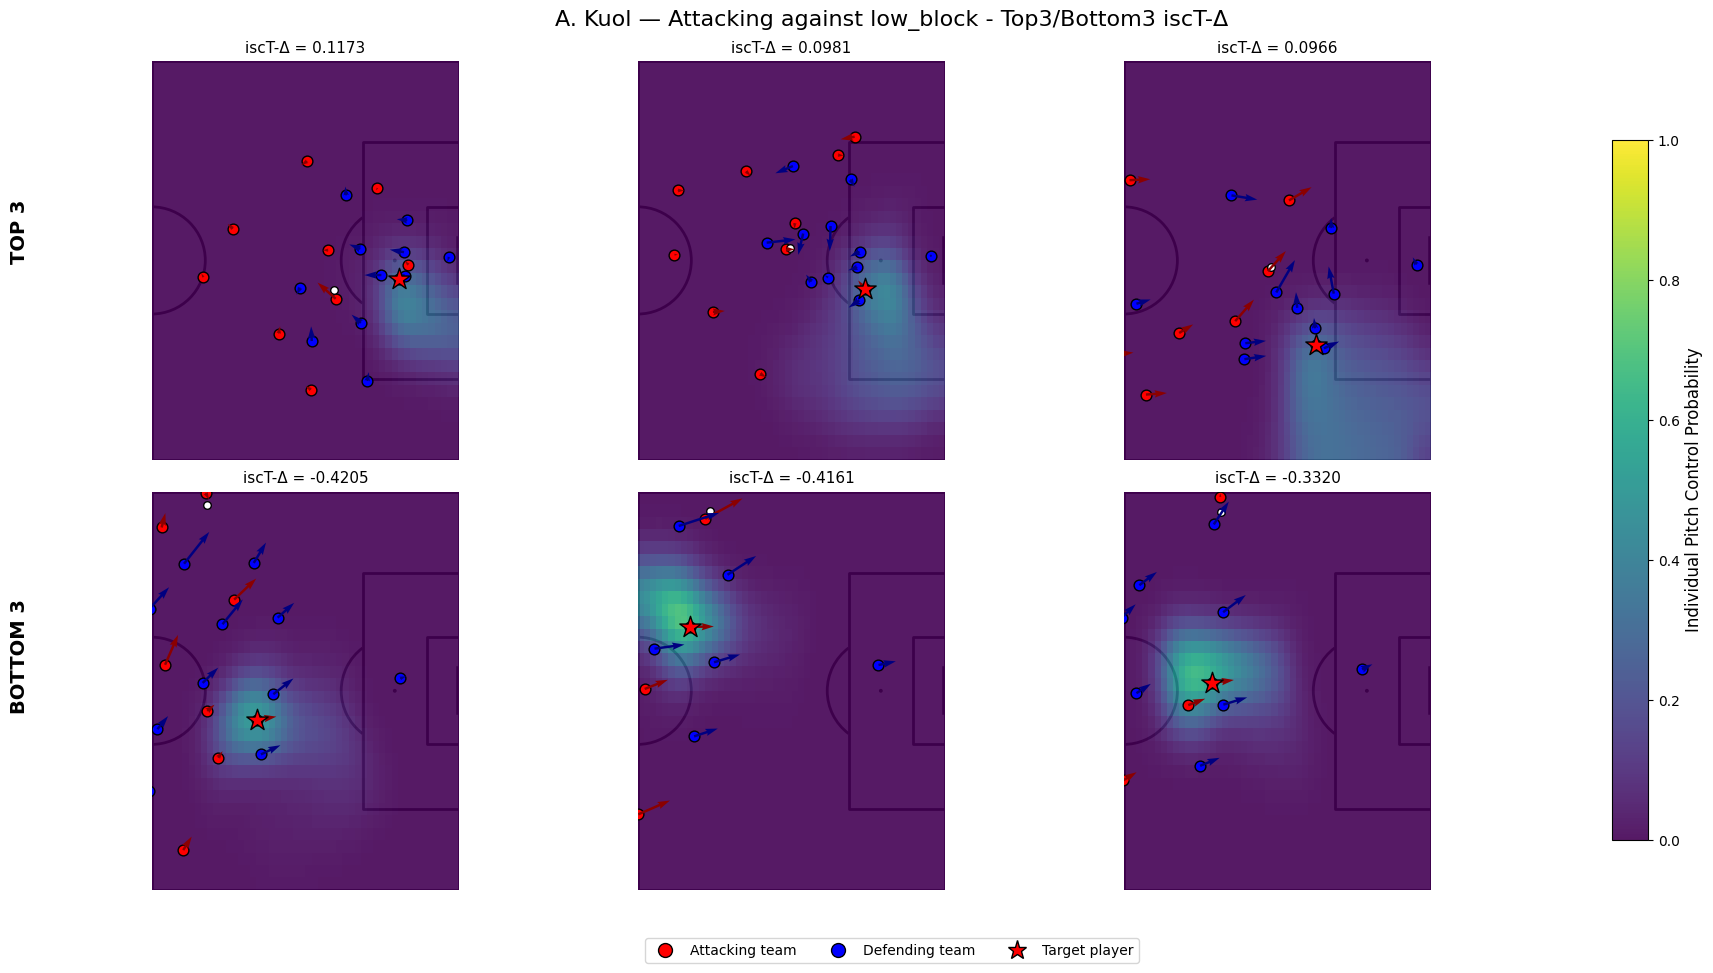

In [60]:
plot_top_bottom_isct_delta(
    player_name= "A. Kuol",
    player_position= player_position,
    game_situation= game_situation,
    save_load_method = "local"
)